# Tariff recommendation

At your disposal is data on the behavior of customers who have already switched to these tariffs. You need to build a model for the classification problem that will select the appropriate rate. Data preprocessing is not required - you have already done it.

Build the model with the largest possible *accuracy* value. To pass the project successfully, you need to bring the percentage of correct answers to at least 0.75. Check *accuracy* on the test set yourself.

_Project execution instructions_

* _Open the data file and examine it._
* _Divide the input data into training, validation and test sets._
* _Explore the quality of different models by changing hyperparameters. Briefly write the findings of the study._
* _Check the quality of the model on the test set._
* _Additional task: check the models for sanity._

## Open and examine the file

In [1]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
path ='/Users/vzuga/Documents/jupyter/'

try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv(path+'/datasets/users_behavior.csv')

In [3]:
df.info()
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB



,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


The file contains the number of calls, minutes, messages, traffic and tariff for each user. Since the preprocessing has already been completed, I will not take any further actions.

The 'calls' column appeared in this file, in the tariff determination project I did not create such a column (in fact, it is count), but used only the total minutes for each user.

Just in case, I’ll check how the number of calls and minutes are related: are they proportional and are there any outliers.

<AxesSubplot:xlabel='calls', ylabel='minutes'>

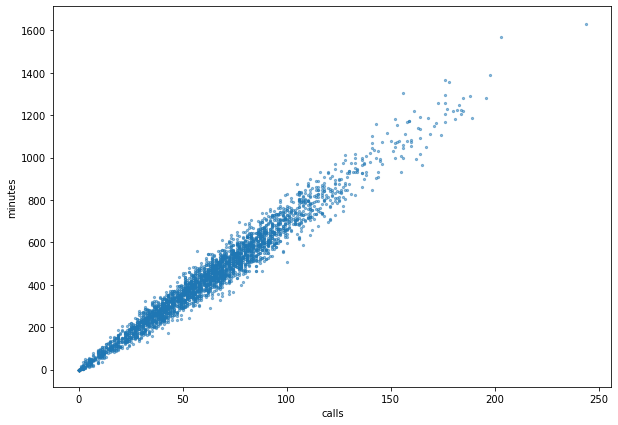

In [4]:
df.plot(kind='scatter', x='calls', y='minutes', alpha=0.5, s=5, figsize=(10,7))

In [5]:
df[['calls','minutes']].corr()

,calls,minutes
calls,1.000000,0.982083
minutes,0.982083,1.000000


There are no outliers, almost 100% correlation.

## Divide the data into samples
I will divide the data into three parts in a ratio of 3:1:1 into training, test and validation samples, respectively.

In [6]:
#extract features and target
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [7]:
#creating samples
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=.25, random_state=12345)

In [8]:
#size check
print(len(features_train), len(features_valid), len(features_test))

1928 643 643


## Explore models

### Decision tree

In [9]:
result_tree = 0
depth_tree = 0
model_tree = None

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    
    if result > result_tree:
        result_tree = result
        depth_tree = depth
        model_tree = model
        
print("Accuracy of the best model:", result_tree)
print('Depth:', depth_tree)

Accuracy of the best model: 0.7744945567651633
Depth: 7


### Random forest

In [10]:
result_forest = 0
depth_forest = 0
est_forest = 0
model_forest = None

for est in range(10, 51, 10):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        
        if result > result_forest:
            model_forest = model
            result_forest = result
            est_forest = est
            depth_forest = depth_forest
            
print("Accuracy of the best model:", result_forest)
print('Depth:', depth_tree)
print('Number of estimators:', est_forest)

Accuracy of the best model: 0.80248833592535
Depth: 7
Number of estimators: 20


### Logistic regression

In [11]:
model_logic = LogisticRegression()
model_logic.fit(features_train, target_train)
result_logic = model_logic.score(features_valid, target_valid)    

print('Accuracy:', result_logic)

Accuracy: 0.7262830482115086


### Conclusions

In [12]:
models = pd.DataFrame(data={'model':['DecisionTree','RandomForest','LogisticRegression'], 
                            'accuracy_valid':[result_tree, result_forest, result_logic]})
models.style.hide_index()

model,accuracy_valid
DecisionTree,0.774495
RandomForest,0.802488
LogisticRegression,0.726283


* the best value of accuracy on the validation set was shown by the random forest model
* logistic regression has the lowest accuracy
* random forest was considered much longer than other models

## Check the model on the test set

In [13]:
result_tree_test = model_tree.score(features_test, target_test)
result_forest_test = model_forest.score(features_test, target_test)
result_logic_test = model_logic.score(features_test, target_test)

In [14]:
models['accuracy_test'] = pd.Series([result_tree_test, result_forest_test, result_logic_test])
models.style.hide_index()

model,accuracy_valid,accuracy_test
DecisionTree,0.774495,0.788491
RandomForest,0.802488,0.785381
LogisticRegression,0.726283,0.758942


On the test set, the decision tree and logistic regression showed higher accuracy (underfitting), while the random forest model was overfitted.

## Check models for sanity

To check for adequacy, I will use a model that will produce a target feature regardless of the input features.

In [15]:
df['is_ultra'].mean()

0.30647168637212197

The actual every third value in the target is one. To begin with, I will compare with the model, which will give the most frequently occurring value from the target (in this case, zero).

In [16]:
model_dummy = DummyClassifier()
model_dummy.fit(features_train, target_train)
result_dummy = model_dummy.score(features_test, target_test)
result_dummy

0.6951788491446346

And compare with a random model (randomly produces zero or one with the same probability).

In [17]:
model_dummy = DummyClassifier(strategy='uniform')
model_dummy.fit(features_train, target_train)
result_dummy = model_dummy.score(features_test, target_test)
result_dummy

0.4727838258164852

In [18]:
model_dummy = DummyClassifier(strategy='most_frequent')
model_dummy.fit(features_train, target_train)
result_dummy = model_dummy.score(features_test, target_test)
result_dummy

0.6951788491446346

The accuracy of all models is higher than the accuracy of dummy models.

## Conclusion

* three models were built for the problem of tariff classification
* all models showed an accuracy greater than or equal to 0.75 on the test set
* the decision tree model turned out to be the most successful - the accuracy is like that of a random forest, but the speed is higher
* all models have been tested for adequacy and found to be adequate